In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob # A module to match regular expressions in this case we want to match all csv files in a folder and flush them out!
import calendar

In [41]:
data_path = "data"

In [42]:
# Lets get all files with their respective paths 
all_csv_files = glob.glob(f'{data_path}/*y.csv')

In [43]:
# Create a function that orders day of week
def order_files_by_day_of_week(files):
    filenames = []
    days = [i.split("/")[1].split(".")[0].title() for i in all_csv_files]
    for ordered_day in list(calendar.day_name):
        if ordered_day in days:
            index = days.index(ordered_day)
            filenames.append(files[index])
    return filenames

In [44]:
# Get ordered files 
files = order_files_by_day_of_week(all_csv_files)

In [45]:
# Read the files
df_list = [pd.read_csv(i, index_col = 0, parse_dates=True, sep=";") for i in files]

In [46]:
# Get abbreviated weekly names from files 
weekly_names = [i.split("/")[1].split(".")[0][0:3] for i in files]

In [47]:
# Put dataframe list into a dictionary 
df_dict = {}
count = 0 
for week_name in weekly_names:
    df_dict[week_name] = df_list[count]
    count += 1
calendar.day_name[calendar.firstweekday()]

'Monday'

In [48]:
# Give unique id to a customer and concatenate into one huge dataframe

df_all = [] 
for key in df_dict.keys():
    df = df_dict[key]
    df["day_of_week"] = df.index.day_name()
    df["customer_no"] = df["customer_no"].astype(str)
    df["shortened_day"] = [i[0:3] for i in df["day_of_week"].tolist()]
    df["customer_id"] = df["customer_no"] + "_" + df["shortened_day"]
    df.drop("shortened_day", axis = 1, inplace=True)
    df_all.append(df)

df_all = pd.concat(df_all)

,customer_no,location,day_of_week,customer_id
timestamp,,,,
2019-09-02 07:03:00,1,dairy,Monday,1_Mon
2019-09-02 07:03:00,2,dairy,Monday,2_Mon
2019-09-02 07:04:00,3,dairy,Monday,3_Mon
2019-09-02 07:04:00,4,dairy,Monday,4_Mon
2019-09-02 07:04:00,5,spices,Monday,5_Mon
...,...,...,...,...
2019-09-06 21:50:00,1500,dairy,Friday,1500_Fri
2019-09-06 21:50:00,1507,checkout,Friday,1507_Fri
2019-09-06 21:50:00,1508,checkout,Friday,1508_Fri


In [49]:
df_mo = pd.read_csv(f'{data_path}/monday.csv', index_col = 0, parse_dates=True, sep=';')
df_tu = pd.read_csv(f'{data_path}/tuesday.csv',  index_col = 0,parse_dates=True, sep=';')
df_we = pd.read_csv(f'{data_path}/wednesday.csv',  index_col = 0,parse_dates=True, sep=';')
df_th = pd.read_csv(f'{data_path}/thursday.csv',  index_col = 0,parse_dates=True, sep=';')
df_fr = pd.read_csv(f'{data_path}/friday.csv',  index_col = 0,parse_dates=True, sep=';')


In [50]:
df_all = pd.concat([df_mo, df_tu, df_we, df_th, df_fr])

In [51]:
df_all.shape

(24877, 2)

In [52]:
df_all['date'] = pd.to_datetime(df_all['timestamp'])

KeyError: 'timestamp'

In [ ]:
df_all['day'] =df_all['date'].dt.day_name()
df_all['hour'] =df_all['date'].dt.hour
df_all.head()

,timestamp,customer_no,location,date,day,hour
0,2019-09-02 07:03:00,1,dairy,2019-09-02 07:03:00,Monday,7
1,2019-09-02 07:03:00,2,dairy,2019-09-02 07:03:00,Monday,7
2,2019-09-02 07:04:00,3,dairy,2019-09-02 07:04:00,Monday,7
3,2019-09-02 07:04:00,4,dairy,2019-09-02 07:04:00,Monday,7
4,2019-09-02 07:04:00,5,spices,2019-09-02 07:04:00,Monday,7


In [ ]:
df_all['location'].value_counts()

checkout    7417
fruit       5122
dairy       4679
drinks      3905
spices      3754
Name: location, dtype: int64

## Calculate the total number of customers in each section

<AxesSubplot:xlabel='location', ylabel='count'>

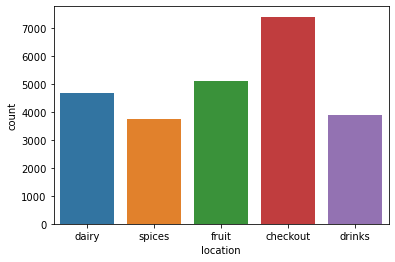

In [ ]:
sns.countplot(x=df_all.location)

## Calculate the total number of customers in each section over time

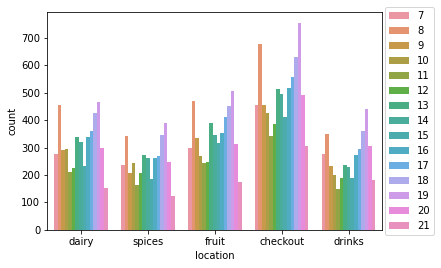

In [ ]:
sns.countplot(x=df_all.location, hue=df_all.hour)
plt.legend(bbox_to_anchor=(1.17, 0.5), loc=5)

## Display the number of customers at checkout over time

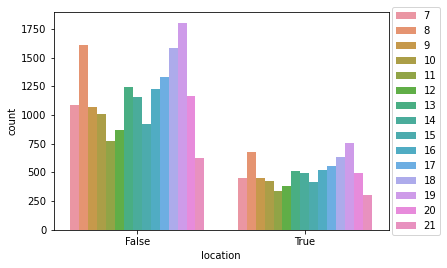

In [ ]:
sns.countplot(x=df_all.location=='checkout', hue=df_all.hour)
plt.legend(bbox_to_anchor=(1.17, 0.5), loc=5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

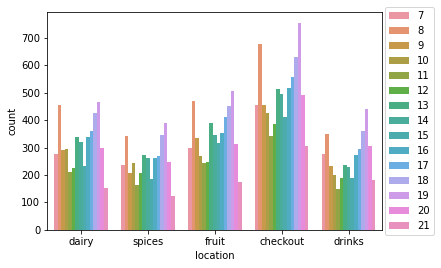

In [ ]:
sns.countplot(x=df_all.location, hue=df_all.hour)
plt.legend(bbox_to_anchor=(1.17, 0.5), loc=5)

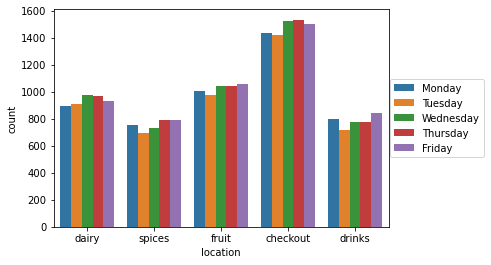

In [ ]:
sns.countplot(data=df_all, x='location', hue='day')
plt.legend(bbox_to_anchor=(1.3, 0.5), loc=5)

## Calculate the time each customer spent in the market


## Calculate the total number of customers in the supermarket over time.

In [ ]:
df_all.isnull().sum()

timestamp      0
customer_no    0
location       0
date           0
day            0
hour           0
dtype: int64